# Assignment 6 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.0 installed. This means, you should be able to use it without any changes to your environment.

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.6G):
```
mkdir -p ~/.torch/models
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/models/models/* ~/.torch/models
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

**Here is an example of the training data:**

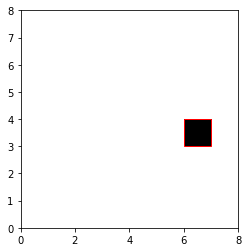

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [0]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [0]:
# This is a fully connected Sequential model with hidden layer having 200 neurons, 
# ReLU nonlinearity and dropout rate of 20%.

model = torch.nn.Sequential(
    torch.nn.Linear(64,200),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(200,4)
).cuda()


In [0]:
# Used Adam: A Method for Stochastic Optimization as my optimizer. It performed really well in this case

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss(size_average=False)

In [0]:
# inputs are made GPU compatabile

inputs = Variable(torch.Tensor(train_X)).cuda()
labels = Variable(torch.Tensor(train_y)).cuda()
inputs_test = Variable(torch.Tensor(test_X)).cuda()

In [0]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(3000):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data.item() * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

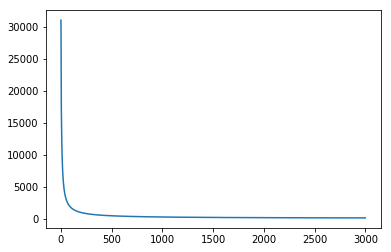

In [0]:
plt.plot(loss_record)

In [0]:
# Predict bounding boxes on the test images.

pred_y = model(inputs_test)
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [0]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

 The Mean IOU for testing data set is :  0.7071082824475835


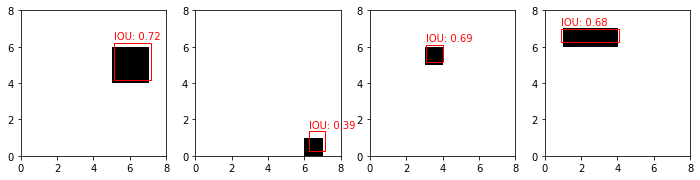

In [0]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
print('\x1b[1;31m','The Mean IOU for testing data set is :','\x1b[0m',mean_IOU)

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6.
You can make the changes that move computation to the GPU directly in the cells above.

# Task 2: Use a pretrained model

As mentioned in class deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.Copy the relevant code into this notebook, as mentioned in the submission instructions.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Display the image and class label in the notebook for submission.

### Hints for step 3

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG19 instead.

Next, print out the new model_conv and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but works similarily. Identify the module that contains the last classification step of the VGG model, which identifies one out of 1000 classes. Change that one into identifying 2 classes only (i.e. the ants and bees that you should start with).

To change the structure of Sequential component called ```module_name``` and to modify its last layer into a DifferentLayer type, you can use this syntax.

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old model_conv.module_name with the differently structured version.

In [0]:
# Importing all neccessary libraries

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# Performing Data Transformations such as cropping, resizing and normalization etc for 
# both testing and training data

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Directory where the image files are present
data_dir = 'hymenoptera_data'

# Transforming the images in the folder based on transformations specified in data_transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Get the list of classes present in training dataset. i.e ['bees', 'ants']
class_names = image_datasets['train'].classes

# Check if GPU is present. Else run on CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

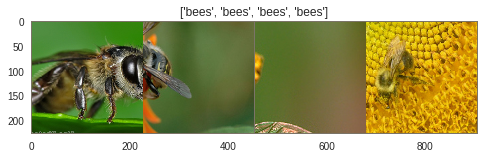

In [27]:
# This function plots the images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
# This function trains the model based on the parameters passed to it
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\x1b[1;31m{} Loss: {:.4f} Acc: {:.4f}\x1b[0m'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# This function tests our model on validation dataset and visualizes our predictions with there labels
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
# 3rd Part
# This function was created by me
# I have specified two models as per the requirement
# We have VGG19  and Alexnet pretrained model

def train_pretrained_model(model_name):
    
    criterion = nn.CrossEntropyLoss()
    # Decay LR by a factor of 0.1 every 7 epochs
    
    if model_name == 'vgg19':
        
        # Initialze vgg19 pretrained model
        model_ft = torchvision.models.vgg19(pretrained=True)
        
        # Observe that only parameters of final layer
        for param in model_ft.parameters():
          param.requires_grad = False
        
        # Change the last layer to have only 2 output features
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
        model_ft = model_ft.to(device)
        optimizer_ft = optim.SGD(model_ft.classifier[6].parameters(), lr=0.001, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        
        #Run the model for 5 epochs
        model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)
        
    elif model_name == 'alexnet':
        # Initialze vgg19 pretrained model
        model_ft = torchvision.models.alexnet(pretrained=True)
        
        # Observe that only parameters of final layer
        for param in model_ft.parameters():
          param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        
         # Change the last layer to have only 2 output features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
        model_ft = model_ft.to(device)
        optimizer_ft = optim.SGD(model_ft.classifier[6].parameters(), lr=0.001, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        
        #Run the model for 5 epochs
        model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)
    
    # Returned the trained model
    return model_ft

 Training using vgg19 pretrained model 

Epoch 0/4
----------
train Loss: 0.2010 Acc: 0.9221
val Loss: 0.0970 Acc: 0.9673

Epoch 1/4
----------
train Loss: 0.1821 Acc: 0.9344
val Loss: 0.1226 Acc: 0.9477

Epoch 2/4
----------
train Loss: 0.1469 Acc: 0.9467
val Loss: 0.1371 Acc: 0.9542

Epoch 3/4
----------
train Loss: 0.1870 Acc: 0.9180
val Loss: 0.1184 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.0987 Acc: 0.9549
val Loss: 0.1386 Acc: 0.9542

Training complete in 1m 3s
Best val Acc: 0.967320
 Testing on vgg19 pretrained model 



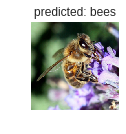

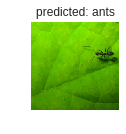

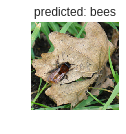

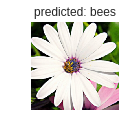

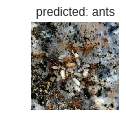

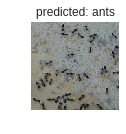

In [13]:
# Training and Testing using vgg19 pretrained model
print('\x1b[1;31m Training using vgg19 pretrained model \x1b[0m\n')
model_ft = train_pretrained_model('vgg19')
print('\x1b[1;31m Testing on vgg19 pretrained model \x1b[0m\n')
visualize_model(model_ft)

 Training using alexnet pretrained model 



Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:02, 92354428.71it/s]


Epoch 0/4
----------
train Loss: 0.7531 Acc: 0.7910
val Loss: 0.7838 Acc: 0.8497

Epoch 1/4
----------
train Loss: 0.5551 Acc: 0.9180
val Loss: 0.7930 Acc: 0.8693

Epoch 2/4
----------
train Loss: 0.6405 Acc: 0.8730
val Loss: 0.7453 Acc: 0.8758

Epoch 3/4
----------
train Loss: 0.4619 Acc: 0.9139
val Loss: 1.1210 Acc: 0.8562

Epoch 4/4
----------
train Loss: 0.3684 Acc: 0.9303
val Loss: 0.7214 Acc: 0.9150

Training complete in 0m 22s
Best val Acc: 0.915033

 Testing on alexnet pretrained model 



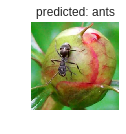

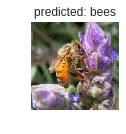

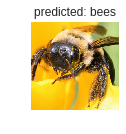

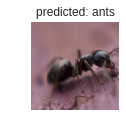

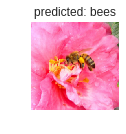

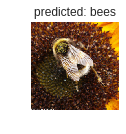

In [14]:
# Training and Testing using alexnet pretrained model
print('\x1b[1;31m Training using alexnet pretrained model \x1b[0m\n')
model_ft = train_pretrained_model('alexnet')
print('\n\x1b[1;31m Testing on alexnet pretrained model \x1b[0m\n')
visualize_model(model_ft)

 Testing on VGG19 Pretrained model using one of our own image  



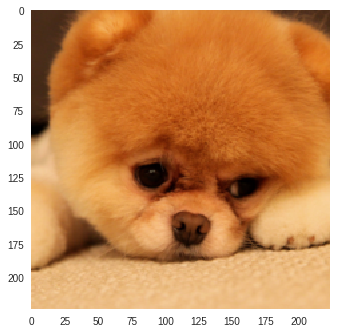


 The image is of 
 Pomeranian


In [24]:
# 4th Part
print ('\x1b[1;31m Testing on VGG19 Pretrained model using one of our own image  \x1b[0m\n')

import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
response = requests.get(LABELS_URL)

# Get labels for 1000 classes
labels = {int(key): value for key, value in response.json().items()}

# Write the directory where the test image os
data_dir = 'test_image'

#Transform the image as specified for validation set
data = datasets.ImageFolder(data_dir, data_transforms['val'])
dataloaders = torch.utils.data.DataLoader(data, batch_size=1,
                                             shuffle=True, num_workers=4)

# Initialize the vgg19 pretrained model
model_ft = torchvision.models.vgg19(pretrained=True)

#Get the test image
test_image = iter(torch.utils.data.DataLoader(data)).next()

# Fit it to our model and get predcitions 
outputs = model_ft(test_image[0])
_, preds = torch.max(outputs, 1)


# Display the image and its predicted value
imshow(test_image[0][0])
print ('\n\x1b[1;31m The image is of \x1b[0m\n',labels[int(preds[0])])

## Submission

For task 1 add your changes to the cells in this notebook.

For task 2 append the required fields of the the transfer learning tutorial to this notebook and make the required modifications. Ensure that you have clear section headings that show where you undertake which parts of the question.

Save this notebook containing all images and upload your submission as one [A6.ipynb](A6.ipynb) file.